In [9]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import seaborn as sns
sns.set_theme()
import datetime as dt
from scipy import stats
import time

In [10]:
# LSEG
import refinitiv.data as rd
import os
rd.open_session(app_key = os.getenv("refinitiv_key"))

<refinitiv.data.session.Definition object at 0x1a17f00f080 {name='workspace'}>

# Historic performance

#### Import etoro account statement

In [11]:
# Import dataset
acc_activity = pd.read_csv('account_activity_seeded.csv')

# Convert dates to DateTime
acc_activity["Date"] = pd.to_datetime(acc_activity["Date"], dayfirst=True)

# Set dates as index
acc_activity.set_index("Date", inplace=True)

# Clean and convert a range of columns to float
columns_to_convert = acc_activity.loc[:, 'Amount':'Balance'].columns

# Remove commas and strip spaces, then convert to float
acc_activity[columns_to_convert] = acc_activity[columns_to_convert].replace(
    {',': '', ' ': ''}, regex=True
).apply(pd.to_numeric, errors='coerce')

#### Convert etoro data to appropriate format

In [12]:
# Get distinct assets
assets = acc_activity[acc_activity['Type'] == 'Open Position']['Details'].unique()

# Initialize an empty list to store DataFrame fragments
transactions_list = []

# Loop through relevant rows in acc_activity
for i, row in acc_activity[acc_activity['Type'].isin(['Open Position', 'Position closed'])].iterrows():
    asset = row['Details']
    units = row['Units'] if row['Type'] == 'Open Position' else -row['Units']

    # Create a temporary df for this row
    temp_df = pd.DataFrame({asset: [units]}, index=[i])

    # Append to the list
    transactions_list.append(temp_df)

# Concatenate all fragments into a single df
transactions = pd.concat(transactions_list, axis=0)

# Pivot to aggregate results by asset
transactions = transactions.groupby(transactions.index).sum()


In [13]:
# Deal with stock splits
for i, row in acc_activity[acc_activity['Type']=='corp action: Split'].iterrows():
    infos = row['Details'].split(' ')

    asset = infos[0]

    # Determine how much is currently held
    asset_held = transactions.loc[:i, asset].cumsum().iloc[-1]

    # Determine split multiple
    multiple = int(infos[1].split(':')[0]) / int(infos[1].split(':')[1])

    # Correct for split
    transactions.loc[:i, asset] = transactions.loc[:i, asset] * multiple

#### Build holdings DF

In [14]:
# Resample and cumsum transactions df to obtain end of day holdings
holdings = transactions.cumsum().resample('D').last().ffill()

# Bring df to current date
holdings = holdings.reindex(pd.date_range(start=holdings.index[0], end=dt.date.today())).ffill()

# Rename columns to exclude '/cur' part
holdings.rename(columns=lambda x: x.split('/')[0], inplace=True)

# Import mapping file as a dict
LSEG_map = pd.read_csv('LSEG_tickers.csv', index_col=0)['LSEG'].to_dict()

# Check for unmapped tickers
unmapped_tickers = []
for ticker in holdings.columns:
    if ticker not in LSEG_map.keys():
        unmapped_tickers.append(ticker)

# Raise error if a ticker isn't mapped
if len(unmapped_tickers) > 0:
    raise ValueError(f'UNMAPPED TICKER(S): {unmapped_tickers}')

# Rename columns to correct tickers
holdings.rename(columns=LSEG_map, inplace=True)

# Sort columns alphabetically
holdings = holdings.sort_index(axis=1)

#### LSEG Retrieval Function

In [15]:
def LSEG_retrieval(universe, fields, parameters={}, timeseries=0, max_attempts=5):

    attempt = 0

    while attempt <= max_attempts:

        # Increment counter
        attempt += 1
        print(f'Attempting LSEG retrieval...')

        try:
            if timeseries == 0:
                # Retrieve info
                retrieval = rd.get_data(
                            universe=universe,
                            fields=fields,
                            parameters=parameters)

            else:
                # Retrieve timeseries
                retrieval = rd.get_history(
                            universe=universe,
                            fields=fields,
                            parameters=parameters)
                
            print('Retrieval successfull!\n')
            break
        
        # Catch error cases
        except Exception as e:
            
            # Re-try API retrieval if condition is met
            if attempt < max_attempts:
                print(f'Attempt {attempt}/{max_attempts} at retrieval of data has failed. Retrying in 3 seconds.')
                time.sleep(3)

            # Throw error after max attempts
            else:
                print(f'Attempt {attempt}/{max_attempts} at retrieval of data has failed. Max attempts reached.\n')
                raise

    return(retrieval)

#### Obtain asset prices

In [16]:
#  Get list of all relevant assets
tickers = holdings.columns.tolist()

# Start and end date
start_date, end_date = holdings.index[0].strftime('%Y-%m-%d'), holdings.index[-1].strftime('%Y-%m-%d')

# Obtain prices
prices = LSEG_retrieval(
                tickers, 
                ['TR.CLOSEPRICE'], 
                parameters = {
                    'SDate': start_date,
                    'EDate': end_date,
                    'Curn': 'USD',
                    'Frq': 'D'
                    },
                timeseries=1
                )

# Drop rows that are filled with 90% NaNs
print(prices.shape)
prices = prices.dropna(thresh=int(len(prices.columns) * 0.1))
print(prices.shape)

Attempting LSEG retrieval...


c:\Users\cedri\AppData\Local\Programs\Python\Python312\Lib\site-packages\refinitiv\data\_tools\_dataframe.py:177:FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Retrieval successfull!

(224, 27)
(224, 27)


In [17]:
print(prices.isna().sum().sum())

# Interpolate missing values
prices = prices.interpolate('linear')

153


#### NAV, returns and HPR

In [18]:
# Calculate NAV (NaNs created bc of non trading days)
NAV = (holdings * prices).dropna()

# Calculate percentage holdings
holdings_pct = NAV.div(NAV.sum(axis=1), axis=0)

# Calculate returns
returns = prices.pct_change()

# Add column for PF
returns['historic_pf'] = (holdings_pct * returns).fillna(0).sum(axis=1)

# Drop first row (no return available)
returns = returns.dropna()

# Calculate HPR
HPR = (returns + 1).cumprod()

# Print cumulative returns
print(HPR.iloc[-1].sort_values())

Close Price
BAES.L         0.874075
IJPE.L         0.976846
MSFT.OQ        0.980173
VERX.DE        0.994862
STX50EEX.DE    0.999294
LMT.N            1.0087
VVSM.DE        1.017882
IDEM.L         1.056652
CEBP.DE        1.082391
SPY4.DE        1.087111
XDEW.DE        1.093218
SAF.PA          1.09841
IUS3.DE        1.102189
ZPRR.DE        1.117936
USCP.DE        1.144059
SPY5.L         1.154541
DJGTEEX.DE     1.176651
CNDX.L         1.177674
historic_pf    1.177878
GOOGL.OQ       1.269861
AMZN.OQ        1.324565
NVDA.OQ        1.348624
AAPL.OQ        1.369807
RHMG.DE         1.38044
META.OQ        1.421424
GE.N           1.478056
TSM.N          1.502233
TSLA.OQ        2.128497
Name: 2025-02-05 00:00:00, dtype: Float64


#### Statistics

In [19]:
# Current 1 year treasury yield
rf = LSEG_retrieval(universe=['USFOMC=ECI'], fields=['CF_LAST']).iloc[0,1] / 100
print(f'Risk free rate: {rf:.2f}%')

# Defining the function
def AnalyseReturns(assets):

    df = pd.DataFrame(index=["Daily Return", "Cumulative Return", "APR", "APY",
                            "Annualised SD", "Sharpe Ratio", "Skewness", "Kurtosis"])
    
    # Initialise plot for display
    plt.figure(figsize=(16,6))

    for asset in assets:

        returns1 = returns[asset]
        
        # Below is self explan, just calculating the necessary info
        Dreturn = returns1.mean()
        Dstd = returns1.std()
        skew = returns1.skew()
        kurt = returns1.kurtosis()
        APR = Dreturn * 252
        APY = ((Dreturn + 1) ** 252) - 1
        Ystd = np.sqrt((Dstd**2) * 252)
        SR = (APR - rf) / Ystd
        cumul = (returns1 + 1).cumprod()
        cumulR = cumul.iloc[-1] - 1 
        
        # Add info to table
        df[asset] = [Dreturn*100, cumulR*100, APR*100, APY*100, Ystd*100, SR, skew, kurt]
    
    return df


def PlotReturns(returns_list, ax=None):

    if ax==None:
        ax = plt.gca()

    for asset_returns in returns_list:
        
        temp_cumul = (asset_returns + 1).cumprod()
        ax.plot(temp_cumul, label=asset_returns.name)

    return ax



Attempting LSEG retrieval...
Retrieval successfull!

Risk free rate: 0.04%


#### ETFs

In [20]:
# Filter for distinct ETFs 
ETFs = pd.Series(acc_activity[acc_activity['Asset type']=='ETF']['Details'].unique())

# Rename assets to match LSEG tickers
ETFs = ETFs.apply(lambda x: x.split('/')[0]).map(LSEG_map)

# Add some key ETFs
ETFs = pd.Series(list(set(ETFs.values) | {'SPY5.L', 'SWDA.L', 'IUS3.DE'}))

# Import relevant information
ETF_info = LSEG_retrieval(
    universe=ETFs.to_list(),
    fields=['TR.FundName',
            'TR.FundBenchmarkName',
            'TR.FundTER',
            'TR.FundCompany',
            'TR.FundIncDistributionIndicator',
            'TR.FundCurrency',]
    )

# Set index to ticker for ease
ETF_info.set_index('Instrument', inplace=True)

Attempting LSEG retrieval...
Retrieval successfull!



# Graphing Functions

#### PlotReturns

In [21]:
def PlotReturns(returns_list, ax=None):

    if ax==None:
        ax = plt.gca()

    for asset_returns in returns_list:
        
        temp_cumul = (asset_returns + 1).cumprod()
        ax.plot(temp_cumul, label=asset_returns.name)

    return ax

#### StackPlot

In [22]:
def StackAnnotate(series, x, ax, side='center', unit='pct'):

    # Add necessary offset
    if side == 'center':
        offset = pd.Timedelta(days=0)
        align = 'center'
    elif side == 'right':
        offset = pd.Timedelta(days=1)
        align = 'left'
    else:
        offset = pd.Timedelta(days=-1)
        align = 'right'

    # Init variable as 0
    bottom = 0

    # Iterate through items
    for i, v in series.items():

        # Skip value if needed
        if (v < 3) or (v == np.nan):
            continue

        # Create label
        label = f'{i} ({v:,.0f}%)' if unit=='pct' else f'{i} (${v:,.2f})'

        # Set top border
        top = v + bottom

        ax.text(
            x=x + offset,  # Slightly offset to the right of the last data point
            y=(top + bottom) / 2,  # Center the text within the stack
            s=label,  # Label
            horizontalalignment=align,  # Align text
            fontsize=10,
            va='center',
        )

        # Current top is next bottom
        bottom = top




def StackPlot(data: pd.DataFrame, ax=None, max_items=5, regularise=True, sort_behavior='overall'):

    # Assign datframe to variable (to avoid modifying original)
    df = data.copy()

    # Assign ax if necessary
    if ax==None:
        ax = plt.gca()

    # Regularise to 100% if needed
    if regularise == True:
        df = df.div(df.sum(axis=1), axis=0) * 100
        unit='pct'
        
    else:
        unit='usd'

    # Create sorting series based on sorting behaviour
    sorting = pd.Series()
    for col in df.columns:
        if sort_behavior == 'overall':
            sorting[col] = df[col].max()
        elif sort_behavior == 'begin':
            sorting[col] = df[col].iloc[0]
        elif sort_behavior == 'end':
            sorting[col] = df[col].iloc[-1]

    # Create list of columns to group into 'others'
    others = sorting.sort_values(ascending=False).iloc[max_items:].index

    # Create the 'others' column
    df['Others'] = df[others].sum(axis=1)

    # Drop excess columns grouped in 'others"
    df.drop(others, axis=1,inplace=True)

    # Prepare data for the stack plot and create it
    y_data = [df[col] for col in df.columns]
    ax.stackplot(df.index, *y_data, labels=df.columns)

    # Add annotations at the end
    StackAnnotate(df.iloc[-1], df.index[-1], ax, side='right', unit=unit)

    return ax
    


#### AdaptivePie

In [23]:
def adaptive_pie(series, ax=None, other_threshold=5):

    # Default is to assign an axis if none is given
    if ax is None:
        ax = plt.gca()

    # Normalise data to percentage
    series = (series / series.sum()) * 100

    # Identify the "Others" category
    below_threshold = series < other_threshold
    if below_threshold.any():  

        # Copy the subset of data that meets the threshold
        data = series[~below_threshold].copy()
        
        # Append the "Others" category separately
        if 'Others' not in series.index:
            data.loc['Others'] = series[below_threshold].sum()
        else:
            raise ValueError('Input should not contain an Others column')

    else:
        data = series.copy()  # If everything is above threshold, copy the original

    # Plot pie chart
    ax.pie(data, labels=data.index, autopct='%1.1f%%')

    return ax


#### TornadoChart

In [24]:
def TornadoChart(portfolio1, portfolio2, pf1_name='Portfolio', pf2_name='Portfolio 2', ax=None, max_items=10, tick=5):

    # Assign ax if necessary
    if ax==None:
        ax = plt.gca()

    # Create merged dataframe
    df = pd.concat([portfolio1, portfolio2], axis=1).fillna(0)
    df.columns = ['pf1', 'pf2']

    # Create differences columns
    df['diff'] = df['pf1'] - df['pf2']
    df['abs_diff'] = df['diff'].abs()

    # Filter for desired values
    df = df.sort_values(by='abs_diff').iloc[-max_items:].sort_values(by='diff')

    # Set y axis length
    y = np.arange(len(df))

    # Plot portfolio 1 allocations (left side)
    ax.barh(y, df['pf1'], color="blue", label=pf1_name, edgecolor="black")

    # Plot portfolio 2 allocations (right side)
    ax.barh(y, -df['pf2'], color="orange", label=pf2_name, edgecolor="black")

    # Plot differences with conditional colors
    colors = ['green' if d > 0 else 'red' for d in df['diff']]  # Green for overweight, red for underweight
    for i in range(len(df)):
        ax.barh(y[i], df['diff'].iloc[i], color=colors[i], alpha=0.9, edgecolor="black", hatch="//")

    # Add annotations
    for k, value in enumerate(df['diff']):
        color = 'green' if value > 0 else 'red'
        sign = '+' if value > 0 else ''
        ax.text(x=value/2, y=k, s=f'{sign}{value:.0f}%', backgroundcolor=color, color='white', ha='center', va='center')

    # Formatting
    ax.set_yticks(y)
    ax.set_yticklabels(df.index)
    ax.set_xlabel("Allocation (%)")
    ax.axvline(0, color="black", linewidth=1)  # Baseline at 0%

    # Modify x-axis to show only positive values
    max_val = round(max(abs(df['pf1']).max(), abs(df['pf2']).max()), )  # Get max allocation
    max_val = round(max_val/tick) * tick
    x_labels = np.arange(-max_val, max_val+tick, tick)  # Ensure symmetrical ticks of 5%
    ax.set_xticks(x_labels)
    ax.set_xticklabels([f"{abs(x):.0f}%" for x in x_labels])  # Show absolute values

    return ax



# Current Holdings

#### Building curr_holdings

Breakdown ETFs

In [25]:
# Create series of currently held assets
curr_holdings_gross = holdings_pct.iloc[-1]

# Retrieve ETF consituents
ETF_compositions = LSEG_retrieval(universe=ETFs.to_list(),
                                fields=['TR.FundHoldingRIC','TR.FundHoldingName',
                                    'TR.FundPercentageOfFundAssets'],
                                parameters={'Endnum':'5000'}
                                )



# Small issue where TSMC has 2 tickers
def TSM_fix(x):
    return 'TSM.N' if x == '2330.TW' else x

ETF_compositions['Holding RIC'] = ETF_compositions['Holding RIC'].map(TSM_fix)

# TSMC also has 2 names (because one is an ADR)
ETF_compositions['Holding Name'] = np.where(ETF_compositions['Holding RIC']=='TSM.N',
                                            'TAIWAN SEMICONDUCTOR MANUFACTURING CO LTD ORD',
                                            ETF_compositions['Holding Name'])



# Add allocation in pf column by multiplying with ETF weight
ETF_compositions['Weight'] = ETF_compositions['Instrument'].map(curr_holdings_gross) * (ETF_compositions['Percentage of Fund Assets'])

# Some assets, like cash don't have a RIC, so eliminate
ETF_compositions = ETF_compositions[ETF_compositions['Holding RIC'] != '']

# Holdings should be higher than 0
ETF_compositions = ETF_compositions[ETF_compositions['Percentage of Fund Assets'] > 0]



# Check for differing names per RIC
ric_to_names = ETF_compositions.groupby('Holding RIC')['Holding Name'].unique()
ric_with_multiple_names = ric_to_names[ric_to_names.apply(len) > 1]

# Check for differing RICs per names
name_to_rics = ETF_compositions.groupby('Holding Name')['Holding RIC'].unique()
name_with_multiple_rics = name_to_rics[name_to_rics.apply(len) > 1]

# Print result
print(f'''Problematic RIC-NAMES: {len(ric_with_multiple_names)}
Problematic NAME-RICS: {len(name_with_multiple_rics)}''')

Attempting LSEG retrieval...
Retrieval successfull!

Problematic RIC-NAMES: 0
Problematic NAME-RICS: 78


Add individually held stocks

In [26]:
# Filter for current stocks held
curr_stocks = curr_holdings_gross[~curr_holdings_gross.index.isin(ETFs)]

# Create temp df to concat
temp = pd.DataFrame(index=range(len(curr_stocks)), columns=ETF_compositions.columns)

# Fill temp df
temp['Instrument'] = curr_stocks.index
temp['Holding RIC'] = curr_stocks.index
temp['Percentage of Fund Assets'] = np.repeat(100, len(curr_stocks))
temp['Weight'] = curr_stocks.values * 100

# Attempt to name asset with know name from ETFs
temp['Holding Name'] = temp['Holding RIC'].map(
    lambda x: ric_to_names[x][0] if x in ric_to_names and len(ric_to_names[x]) > 0 else x)

# Concat to get total current holdings
curr_holdings = pd.concat([ETF_compositions, temp], axis=0)

# Print total weight of pf
tot_alloc = curr_holdings['Weight'].sum()
print(f'Total allocation: {tot_alloc}')


Total allocation: 100.27291883753242


#### Asset details (add info)

In [27]:
# Obtain RICs to retrieve information
assetRICs = curr_holdings['Holding RIC'].unique().tolist()

def add_info(name, field, parameters={}, max_attempts=5):

    # Retrieve LSEG data
    info = LSEG_retrieval(assetRICs,[field], parameters=parameters, max_attempts=max_attempts)

    # Checking for data type to handle unknowns gracefully
    if pd.api.types.is_numeric_dtype(info.iloc[:,1]):
        
        # Convert to a series for ease
        info = (info.set_index('Instrument')).iloc[:, 0].replace('', np.NaN)

        # Update curr_holdings df
        curr_holdings[name] = curr_holdings['Holding RIC'].map(info).fillna(np.NaN)

        # Print unknowns
        print(f'Unknowns: {tot_alloc - curr_holdings.groupby(name)['Weight'].sum().sum():.2F}%')

    else:

        # Convert to a series for ease
        info = (info.set_index('Instrument')).iloc[:, 0].replace('', 'Unknown')

        # Update curr_holdings df
        curr_holdings[name] = curr_holdings['Holding RIC'].map(info).fillna('Unknown')

        # Print unknowns
        print(f'Unknowns: {curr_holdings.groupby(name)['Weight'].sum().get('Unknown'):.2F}%')

In [28]:
add_info('Sector', 'TR.GICSSector')

Attempting LSEG retrieval...
Retrieval successfull!

Unknowns: 0.52%


In [29]:
add_info('Industry Group', 'TR.GICSIndustryGroup')

Attempting LSEG retrieval...
Retrieval successfull!

Unknowns: 0.52%


In [30]:
add_info('Industry', 'TR.GICSIndustry')

Attempting LSEG retrieval...
Retrieval successfull!

Unknowns: 0.52%


In [31]:
add_info('Market Cap (USD)', 'TR.IssueMarketCap', parameters={'Curn': 'USD'})

# Add classification column
def classifyCap(mkt_cap):

    # Default to unknown (for NaNs)
    classification = 'Unknown'

    # Define lists (in billions)
    caps_threshold = pd.Series([0, 0.05, 0.3, 2, 10, 200, 1000]) * (10 ** 9)
    class_list = pd.Series(['Nano', 'Micro', 'Small', 'Mid', 'Large', 'Mega', 'Trillion']) + ' Cap'

    # Match classification to range
    for i in reversed(range(len(caps_threshold))):
        if caps_threshold[i] <= mkt_cap:
            classification = class_list[i]
            break
    
    return classification

curr_holdings['Market Cap'] = curr_holdings['Market Cap (USD)'].map(classifyCap)

Attempting LSEG retrieval...


c:\Users\cedri\AppData\Local\Programs\Python\Python312\Lib\site-packages\refinitiv\data\_tools\_dataframe.py:192:FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
c:\Users\cedri\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1056:RuntimeWarning: invalid value encountered in cast
c:\Users\cedri\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1080:RuntimeWarning: invalid value encountered in cast


Retrieval successfull!

Unknowns: 0.43%


In [32]:
add_info('Region', 'TR.HeadquartersRegion')

Attempting LSEG retrieval...
Retrieval successfull!

Unknowns: 0.01%


In [33]:
add_info('Country', 'TR.HeadquartersCountry')

Attempting LSEG retrieval...
Retrieval successfull!

Unknowns: 0.01%


In [34]:
add_info('PE', 'PERATIO')

Attempting LSEG retrieval...
Retrieval successfull!

Unknowns: 3.10%


#### InspectDF Function
(Description generated with chatGPT)

In [35]:
def inspectDF(category, filter_statement='none', other_threshold=1, instrument='portfolio', regularise='yes'):
    '''
    The inspectDF function processes and analyzes a dataset (assumed to be `curr_holdings`), 
    filtering and summarizing it based on a given category, with optional additional conditions 
    such as filtering, weight regularization, and grouping.

    Parameters:
    - category (str): The column in the dataframe (`curr_holdings`) to group by, 
      such as 'Sector' or 'Instrument'.
    - filter_statement (str, default='none'): A condition to filter the dataframe. 
      The format should be 'ColumnName=Value'. If 'none', no filtering is applied.
    - other_threshold (int, default=1): The weight threshold used to group smaller categories 
      into an "Others" row.
    - instrument (str, default='portfolio'): The instrument type to inspect, either 'portfolio' 
      or a specific instrument name. Determines the column used for weight data.
    - regularise (str, default='yes'): If 'yes', the function will regularize the weights 
      in the grouped data so that the total weight sums to 100%.

    Returns:
    - DataFrame: A grouped and processed dataframe, with the sum of weights for each category, 
      with weights optionally regularized to sum to 100%, and any categories with weights below 
      the threshold combined into an "Others" category.

    Function Workflow:
    1. The function checks whether a filter is applied using `filter_statement`. If provided, 
       it subsets the dataframe based on the condition (e.g., `Sector=Industrials`).
    2. Depending on the selected `instrument`, it assigns the appropriate weight column 
       (`'Weight'` for portfolio, `'Percentage of Fund Assets'` for other instruments).
    3. It groups the dataframe by the specified category and calculates the total weight for each group.
    4. If the `regularise` parameter is set to `'yes'`, the weight column is normalized so 
       that the sum of all weights equals 100%.
    5. It aggregates all categories with weights below the `other_threshold` into an "Others" row.
    6. The resulting dataframe, with summed weights, is returned.

    Example Usage:
    grouped_df = display(inspectDF('Region', filter_statement='Industry=Aerospace & Defense',
                 other_threshold=1, regularise='no'))
    '''


    # Adjust df to match instrument inspected 
    if filter_statement == 'none':

        # No need to subset if there are no filters
        df = curr_holdings

    else:

        # Gracefully handle errors with a try statement
        try:
            # Set filter and target from statement (ex: Industry=Aerospace & Defense)
            filt, target = filter_statement.split('=')[0], filter_statement.split('=')[1]
        except:
            raise ValueError('Filter Statement should be structured as ColumnName=Value')
        
        # Subset df for desired filter
        df = curr_holdings[curr_holdings[filt]==target]


    # Choose correct targeted weight and filter for instrument desired
    if instrument == 'portfolio':
        weight_col = 'Weight'
    else:
        weight_col = 'Percentage of Fund Assets'
        df = df[curr_holdings['Instrument']==instrument]

    # Group by desired category
    grouped_df = df.groupby(category)[weight_col].sum().sort_values(ascending=False).to_frame(name='Weight')

    # Regularise df weights to 100 percent
    if regularise == 'yes':
        grouped_df['Weight'] = (grouped_df['Weight'] / grouped_df['Weight'].sum()) * 100

    # Check if entries do not meet threshold
    if other_threshold != 0:
      if not grouped_df[grouped_df['Weight'] < other_threshold].empty:
          others = grouped_df[grouped_df['Weight'] < other_threshold]['Weight'].sum() # Aggregate small weights
          grouped_df = grouped_df[grouped_df['Weight'] >= other_threshold] # Subset data that meets threshold
          grouped_df.loc['Others', 'Weight'] = others # Add entry for "others"

    # Return df (for ease of display, df)
    return grouped_df


# Example: examining the breakdown of aerospace&defense companies within the portfolio based on country
inspectDF('Country', filter_statement='Industry=Aerospace & Defense', other_threshold=5, regularise='yes')


,Weight
Country,
Germany,51.113301
United States of America,33.888253
France,14.622236
Others,0.37621


In [36]:
inspectDF('Holding RIC', other_threshold=1).head(3)

,Weight
Holding RIC,
TSM.N,9.417494
RHMG.DE,7.948827
AAPL.OQ,4.799815


#### HoldingEvolution Function

In [37]:
def HoldingEvolution(df: pd.DataFrame, filter: str):

    tempdf_list = []

    # Assets that need to be iterated through
    holds = df.columns.to_list()
    
    for i in holds:

        # Obtain relevant weights
        temp = inspectDF(filter, instrument=i, other_threshold=0)['Weight']/100

        # Create temporary df
        temp_df = pd.DataFrame(data=temp.to_list(), index=temp.index, columns=[i]).transpose()
        temp_df.index.name = 'Intrument'

        # Append the temp_df to the result list
        tempdf_list.append(temp_df)

    # Concatenate the temporary dfs
    key_df = pd.concat(tempdf_list, axis=0)

    # Fill missing values with 0
    key_df.fillna(0, inplace=True)

    return df.dot(key_df)



# Analysing the pf

In [38]:
print(f'Portfolio PE ratio: {(curr_holdings['PE'] * curr_holdings['Weight']).sum()/100:.2f}')

spy5_holdings = curr_holdings[curr_holdings['Instrument'] == 'SPY5.L']

print(f'SPY PE ratio: {(spy5_holdings['PE'] * spy5_holdings['Percentage of Fund Assets']).sum()/100:.2f}')
print(f'SPY PE ratio (simple): {spy5_holdings['PE'].mean():.2f}')

Portfolio PE ratio: 43.83
SPY PE ratio: 46.97
SPY PE ratio (simple): 38.94


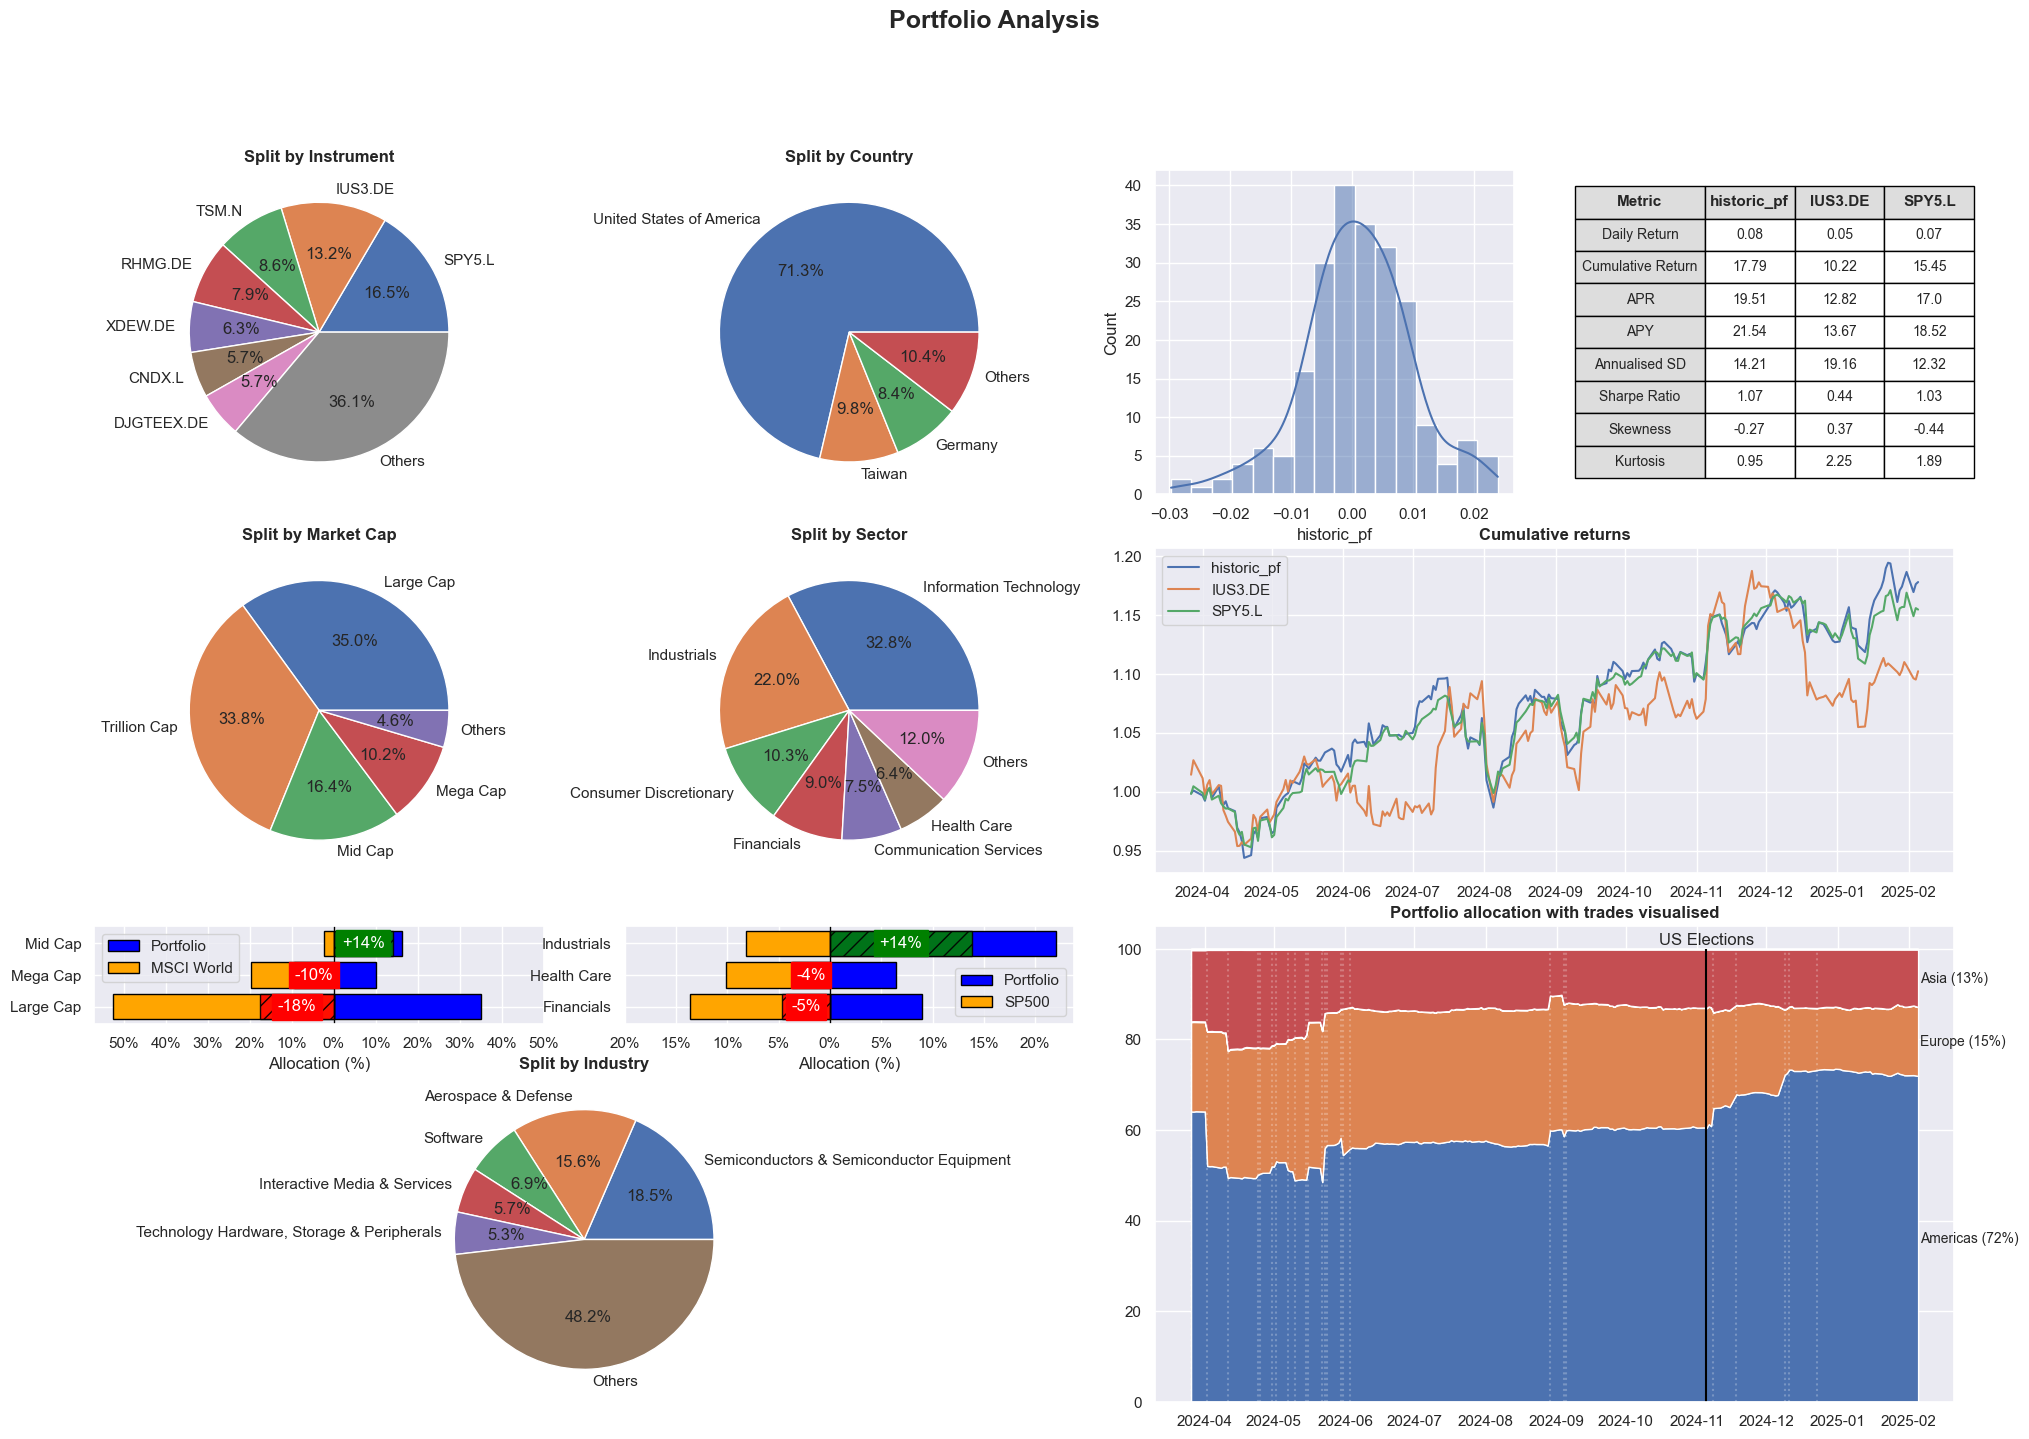

<Figure size 1600x600 with 0 Axes>

In [39]:
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 0.3, 1], width_ratios=[1, 1, 0.8, 0.8])  # Define GridSpec



field = ['Instrument', 'Country', 'Market Cap', 'Sector']
axs = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(len(field))]  # Create only necessary subplots

# Plot pie charts for fields
for i, ax in enumerate(axs):
    df = inspectDF(field[i], other_threshold=0)  # Ensure this returns a valid DataFrame
    adaptive_pie(df['Weight'], ax=ax)
    ax.set_title(f'Split by {field[i]}', fontweight='bold', fontsize=12)



# Add comparative weighing for market cap
mktcap_ax = fig.add_subplot(gs[2, 0])   # Allocate ax
portfolio_alloc_mktcap = inspectDF('Market Cap', other_threshold=0)['Weight']   # Get data
world_alloc_mktcap = inspectDF('Market Cap', instrument='SWDA.L', other_threshold=0)['Weight']   # Get data
TornadoChart(portfolio_alloc_mktcap, world_alloc_mktcap, max_items=3, 
             pf1_name='Portfolio', pf2_name='MSCI World', ax=mktcap_ax, tick=10)  # Graph
mktcap_ax.legend(loc='upper left')



# Add comparative weighing for sector
sector_ax = fig.add_subplot(gs[2, 1])   # Allocate ax
portfolio_alloc_sec = inspectDF('Sector', other_threshold=0)['Weight']   # Get data
sp500_alloc_sec = inspectDF('Sector', instrument='SPY5.L', other_threshold=0)['Weight']   # Get data
TornadoChart(portfolio_alloc_sec, sp500_alloc_sec, max_items=3, 
             pf1_name='Portfolio', pf2_name='SP500', ax=sector_ax)   # Graph
sector_ax.legend()



# Industry plot 2 cols
bottom_ax = fig.add_subplot(gs[3, 0:2])  
adaptive_pie(inspectDF('Industry', other_threshold=0)['Weight'], ax=bottom_ax)
bottom_ax.set_title('Split by Industry', fontweight='bold', fontsize=12)



# Show returns
cumul_ax = fig.add_subplot(gs[1, 2:4])
PlotReturns([returns['historic_pf'], returns['IUS3.DE'], returns['SPY5.L']], ax=cumul_ax)
cumul_ax.legend()
cumul_ax.set_title('Cumulative returns', fontweight='bold', fontsize=12)



# Add histplot of returns
hist_ax = fig.add_subplot(gs[0, 2])
sns.histplot(returns['historic_pf'], kde=True, ax=hist_ax)



# Add portfolio stats
stats_ax = fig.add_subplot(gs[0, 3])  # Create subplot
stats_ax.axis("off")  # Hide axes

# Get DataFrame, round values to 2 decimals, and reset index
stats_df = AnalyseReturns(['historic_pf', 'IUS3.DE', 'SPY5.L']).round(2)
stats_df.insert(0, "Metric", stats_df.index)  # Move index to column
stats_df.reset_index(drop=True, inplace=True)  # Reset original index

# Convert DataFrame to string format for display
table = stats_ax.table(cellText=stats_df.values.astype(str),  
                       colLabels=stats_df.columns,  
                       cellLoc="center",  
                       loc="center",  
                       colColours=["#f2f2f2"] * len(stats_df.columns))  # Light gray header background

# Improve styling
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjust cell height and width for better readability
for key, cell in table.get_celld().items():
    cell.set_edgecolor("black")  # Add cell borders
    if key[0] == 0:  # Header row
        cell.set_fontsize(11)
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#dddddd")  # Darker gray for header
    cell.set_height(0.1)  # Increase row height
    cell.set_width(0.25)  # Adjust width

    if key[1] == 0: # Index col
        cell.set_facecolor("#dddddd")
        cell.set_width(0.36)




# Add holding evolution df
evo_ax = fig.add_subplot(gs[2:4, 2:4])
StackPlot(HoldingEvolution(NAV, 'Region'), max_items=5, ax=evo_ax, regularise=True)

# Add vline for US elections
evo_ax.vlines(x=pd.to_datetime('2024-11-05'), ymin=0, ymax=100, colors='black')
evo_ax.text(x=pd.to_datetime('2024-11-05'), y=101, s='US Elections', horizontalalignment='center')

# Add vlines corresponding to trades
for date in transactions.index.to_period('D').unique():
    evo_ax.vlines(x=date, ymin=0, ymax=100, colors='white', linestyles=':', alpha=0.25)

evo_ax.set_title('Portfolio allocation with trades visualised', fontweight='bold', fontsize=12)



fig.suptitle('Portfolio Analysis', fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()
